# **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,  
    classification_report,
    # mean_absolute_error, 
    # mean_squared_error, 
    # explained_variance_score,
    f1_score,
    precision_score,
    recall_score
)

from imblearn.over_sampling import RandomOverSampler

from keras.src.models import Sequential
from keras.src.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, LSTM, 
    Bidirectional, Reshape, Dropout, Dense, Activation
)

# **2. Read data**

In [3]:
# Read normalized training data
normalized_data = pd.read_csv('../processed_data/normalized_data.csv')
X = normalized_data.drop('attack_cat', axis=1)
y = normalized_data['attack_cat']

In [4]:
X

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
257669,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
257670,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
257671,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y

0         Normal
1         Normal
2         Normal
3         Normal
4         Normal
           ...  
257668    Normal
257669    Normal
257670    Normal
257671    Normal
257672    Normal
Name: attack_cat, Length: 257673, dtype: object

# **3. Initialize Cross-Validation technique and handle data imbalance**

In [ ]:
# Balance the data by duplicating the minority class
oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
# Split the data into 6 parts while maintaining the label ratio
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
kfold.get_n_splits(X, y)

6

# **4. Building CNN - BiLSTM model**

In [7]:
# CNN - BiLSTM model
batch_size = 32
model = Sequential()

model.add(Conv1D(64, kernel_size=64, padding="same", activation="relu", input_shape=(196, 1)))  # CNN 1D
model.add(MaxPooling1D(pool_size=10))   # Max Pooling để giảm chiều dữ liệu
model.add(BatchNormalization())     # Chuẩn hóa dữ liệu để tăng tốc độ hội tụ

model.add(Bidirectional(LSTM(64, return_sequences=False)))  # LSTM 2 chiều để học quan hệ thời gian
model.add(Reshape((128, 1), input_shape=(128, )))   # Định hình lại đàu ra cho phù hợp
model.add(MaxPooling1D(pool_size=5))    # Thêm 1 lớp pooling
model.add(BatchNormalization())     # Chuẩn hóa dữ liệu lần 2

model.add(Bidirectional(LSTM(128, return_sequences=False)))     # LSTM 2 chiều thứ 2
model.add(Dropout(0.6))     # Loại bỏ 60% noron để giảm overfiting

model.add(Dense(10))    # Lớp đầu ra với 10 lớp phân loại
model.add(Activation('softmax'))    # Hàm kích hoạt softmax cho bài toán phân loại nhiều lớp

c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 196, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,158 (805.30 KB)

 Trainable params: 206,028 (804.80 KB)

 Non-trainable params: 130 (520.00 B)

# **5. Train the model using Cross-Validation**

In [ ]:
# List to store each fold
oos_pred = []
def lr_schedule(epoch):
   return 0.01 if epoch < 30 else 0.001

In [ ]:
# Start time
start_time = time.time()

# Cross-validation loop
for train_index, val_index in kfold.split(X=X, y=y):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]


    print("train index: ", train_index)
    print("test index: ", val_index)
    print(y_train.value_counts())

    # Balance the data using RandomOverSamplt
    # X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

    # Convert training data to Numpy format
    X_train_array = X_train.values
    X_train_np = np.reshape(X_train_array, (X_train_array.shape[0], X_train_array.shape[1], 1))

    # One hot encoding for training lables
    y_train_one_hot = pd.get_dummies(y_train)
    y_train_np = y_train_one_hot.values

    # Convert validation data to Numpy format
    X_test_array = X_test.values
    X_test_np = np.reshape(X_test_array, (X_test_array.shape[0], X_test_array.shape[1], 1))

    # One hot encoding for testing lables
    y_test_one_hot = pd.get_dummies(y_test)
    y_test_np = y_test_one_hot.values

    # Train the model wwith 9 epochs
    model.fit(X_train_np, y_train_np, validation_data=(X_test_np, y_test_np), epochs=100, callbacks = [lr_schedule])

    # Predict on test data
    y_pred = model.predict(X_test_np)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Lấy nhãn có xác suất cao nhất
    y_test_labels = np.argmax(y_test_np, axis=1)     # Chuyển nhãn thực tế về dạng số nguyên

    # Caculate accouracy and save the results
    score = metrics.accuracy_score(y_test_labels, y_pred_labels)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

# End time
end_time = time.time()
training_time = end_time - start_time

train index:  [     0      1      2 ... 257669 257670 257672]
test index:  [     9     14     15 ... 257658 257668 257671]
attack_cat
Normal            77500
Generic           49059
Exploits          37104
Fuzzers           20205
DoS               13628
Reconnaissance    11656
Analysis           2231
Backdoor           1940
Shellcode          1259
Worms               145
Name: count, dtype: int64
Epoch 1/100
6711/6711 ━━━━━━━━━━━━━━━━━━━━ 112s 16ms/step - accuracy: 0.7319 - loss: 0.7012 - val_accuracy: 0.7707 - val_loss: 0.5592
Epoch 2/100
6711/6711 ━━━━━━━━━━━━━━━━━━━━ 104s 15ms/step - accuracy: 0.7787 - loss: 0.5550 - val_accuracy: 0.7882 - val_loss: 0.5204
Epoch 3/100
6711/6711 ━━━━━━━━━━━━━━━━━━━━ 106s 16ms/step - accuracy: 0.7935 - loss: 0.5201 - val_accuracy: 0.8033 - val_loss: 0.4975
Epoch 4/100
6711/6711 ━━━━━━━━━━━━━━━━━━━━ 107s 16ms/step - accuracy: 0.7991 - loss: 0.5063 - val_accuracy: 0.7999 - val_loss: 0.5026
Epoch 5/100
6711/6711 ━━━━━━━━━━━━━━━━━━━━ 108s 16ms/step - accu

KeyboardInterrupt: 

In [11]:
# Out-of-sample predictions
oos_pred

[0.8055930703674382,
 0.8142551110697155,
 0.8168630373026592,
 0.8196530445919199,
 0.8200256141576435,
 0.8245663057398999]

In [12]:
# AVG accuracy for each fold
mean_accuracy = np.mean(oos_pred)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy}")


Mean Cross-Validation Accuracy: 0.8168260305382127


In [13]:
# Count the Number of Samples per Class
y_test.value_counts()

attack_cat
Normal            15500
Generic            9812
Exploits           7421
Fuzzers            4041
DoS                2725
Reconnaissance     2331
Analysis            446
Backdoor            388
Shellcode           252
Worms                29
Name: count, dtype: int64

In [14]:
# One hot encoding lables
y_test_one_hot.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
      dtype='object')

In [15]:
# Save model
model.save("../models/CNN_BiLSTM.h5")

# **6. Plot Confusion Matrix and Model Evaluation Graphs**

In [16]:
confusion_matrix_result = confusion_matrix(y_test_labels, y_pred_labels, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [17]:
confusion_matrix_result

array([[   24,     0,    25,   263,    71,     0,    63,     0,     0,
            0],
       [    0,    26,    43,   241,    66,     2,     1,     6,     3,
            0],
       [    0,     5,   458,  2104,    80,    10,    32,    14,    22,
            0],
       [    0,     7,   396,  6479,   195,    21,   188,    91,    41,
            3],
       [    1,     0,    43,   336,  2401,     2,  1198,    43,    17,
            0],
       [    0,     1,    17,   153,    11,  9618,     9,     0,     3,
            0],
       [    0,     0,     2,    80,   827,     2, 14486,    80,    23,
            0],
       [    0,     2,    73,   438,     6,     4,    43,  1759,     6,
            0],
       [    0,     0,     2,    30,    20,     3,    19,    25,   153,
            0],
       [    0,     0,     0,    19,     2,     0,     1,     0,     0,
            7]], dtype=int64)

In [18]:
# Compute confusion matrix
def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True
):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [19]:
# Set target names
target_names=[
    'Analysis', 
    'Backdoor', 
    'DoS', 
    'Exploits', 
    'Fuzzers', 
    'Generic', 
    'Normal', 
    'Reconnaissance', 
    'Shellcode', 
    'Worms'
]

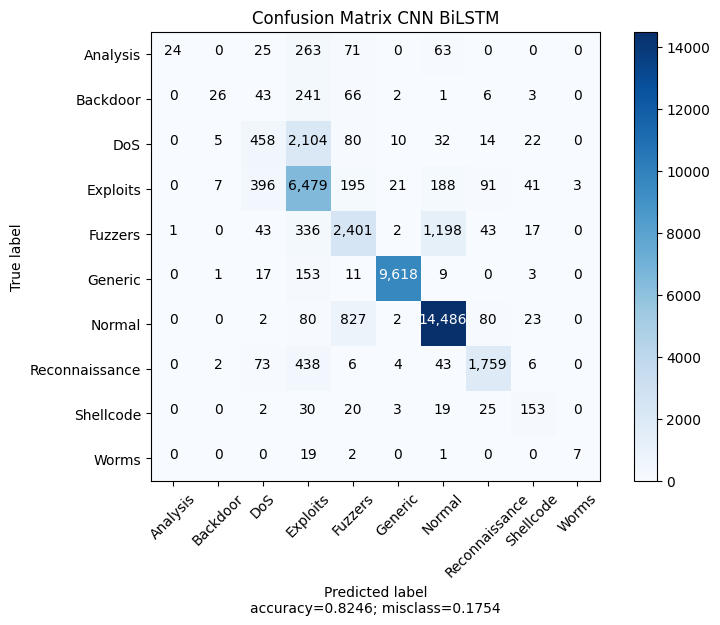

In [20]:
# Plot confusion matrix
plot_confusion_matrix(
    confusion_matrix_result, 
    normalize=False,
    target_names=target_names, 
    title="Confusion Matrix CNN BiLSTM"
)

# **7. Calculate metrics**

In [21]:
# Training time
training_time = end_time - start_time
print(f"Training time: {training_time/60/60:.2f} hours")

Training time: 2.31 hours


In [22]:
# Tính Detection Rate và False Positive Rate
tp = np.diag(confusion_matrix_result)  # True Positives
fn = np.sum(confusion_matrix_result, axis=1) - tp  # False Negatives
fp = np.sum(confusion_matrix_result, axis=0) - tp  # False Positives

In [23]:
detection_rate = tp / (tp + fn)
fpr = fp / (fp + np.sum(confusion_matrix_result, axis=1) - tp)
df = pd.DataFrame({"Class": target_names, "False Positive Rate": fpr, "Detection Rate": detection_rate})

# Hiển thị bảng
print(df)

            Class  False Positive Rate  Detection Rate
0        Analysis             0.002364        0.053812
1        Backdoor             0.039788        0.067010
2             DoS             0.209554        0.168073
3        Exploits             0.795484        0.873063
4         Fuzzers             0.437971        0.594160
5         Generic             0.184874        0.980228
6          Normal             0.605140        0.934581
7  Reconnaissance             0.311673        0.754612
8       Shellcode             0.537383        0.607143
9           Worms             0.120000        0.241379


In [24]:
# Hiển thị báo cáo phân loại
print(classification_report(y_test_labels, y_pred_labels, target_names=target_names))

                precision    recall  f1-score   support

      Analysis       0.96      0.05      0.10       446
      Backdoor       0.63      0.07      0.12       388
           DoS       0.43      0.17      0.24      2725
      Exploits       0.64      0.87      0.74      7421
       Fuzzers       0.65      0.59      0.62      4041
       Generic       1.00      0.98      0.99      9812
        Normal       0.90      0.93      0.92     15500
Reconnaissance       0.87      0.75      0.81      2331
     Shellcode       0.57      0.61      0.59       252
         Worms       0.70      0.24      0.36        29

      accuracy                           0.82     42945
     macro avg       0.74      0.53      0.55     42945
  weighted avg       0.82      0.82      0.81     42945



In [ ]:
# print("Mean Absolute Error - ", mean_absolute_error(y_test, y_pred))
# print("Mean Squared Error - ", mean_squared_error(y_test, y_pred))
# print("Root Mean Squared Error - ", np.sqrt(mean_squared_error(y_test, y_pred)))
# print("R2 Score - ", explained_variance_score(y_test, y_pred) * 100)
print("F1 Score (weighted): ", f1_score(y_test, y_pred, average='weighted') * 100)
print("Accuracy - ",accuracy_score(y_test, y_pred, average='weighted') * 100)
print("Precision - ",precision_score(y_test, y_pred, average='weighted') * 100)
print("Recall - ", recall_score(y_test, y_pred, average='weighted') * 100)

Mean Absolute Error -  0.34478984747933406
Mean Squared Error -  0.9110490161834905
Root Mean Squared Error -  0.9544888769302085
R2 Score -  61.484050936382204
F1 Score (weighted):  80.83592918795402
Accuracy -  82.45663057398998
